In [1]:
pip install segmentation_models_pytorch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import os
from PIL import Image
import cv2
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import random

/Users/pg/Desktop/code/Ingredient_Segmentation/metal-tf215/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch

if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


In [5]:
print("CUDA available:", torch.cuda.is_available())
print("MPS available:", hasattr(torch.backends, 'mps') and torch.backends.mps.is_available())
print("Device:", device)

CUDA available: False
MPS available: True
Device: mps


In [6]:
BATCH_SIZE = 8
LR = 0.0003
EPOCHS = 60

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CompositeSegLoss(nn.Module):
    """
    CE + Dice (또는 IoU) 복합 손실.
    - 다중클래스 지원
    - ignore_index 지원 (예: 255)
    - class_weight (희귀 클래스 가중치) 옵션
    """
    def __init__(self,
                 num_classes: int,
                 ignore_index: int = 255,
                 ce_weight: float = 0.7,
                 dice_weight: float = 0.3,
                 use_iou: bool = False,                # True면 CE+IoU, False면 CE+Dice
                 class_weight: torch.Tensor | None = None,  # shape [C]
                 eps: float = 1e-6,
                 use_ohem: bool = True,      # ★ 추가
                 ohem_ratio: float = 0.2,    # ★ 추가 (상위 20% 픽셀만)
                 ohem_min_kept: int = 10000  # ★ 추가 (최소 픽셀 수)
                 ):
        super().__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.ce_w = ce_weight
        self.dice_w = dice_weight
        self.use_iou = use_iou
        self.eps = eps
        self.use_ohem = use_ohem
        self.ohem_ratio = ohem_ratio
        self.ohem_min_kept = ohem_min_kept
        self.class_weight = class_weight

        self.ce = nn.CrossEntropyLoss(
            ignore_index=ignore_index,
            weight=class_weight,  # None 또는 [C] 텐서
            label_smoothing=0.05   # ★ 추가

        )
        self.ce_no_reduce = lambda x,y,w: F.cross_entropy(
            x, y, ignore_index=self.ignore_index, weight=self.class_weight, reduction='none',label_smoothing=0.05
        )

        # Dice/IoU에서의 클래스 가중치 (선택)
        if class_weight is not None:
            # 평균 1.0로 정규화(너무 큰 가중 폭주 방지)
            self.soft_w = class_weight / (class_weight.mean() + 1e-8)
        else:
            self.soft_w = None

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        logits: [B, C, H, W]  (model output, LogSoftmax 아님!)
        targets: [B, H, W]    (long, 클래스 ID, ignore_index 포함 가능)
        """
        targets = targets.long()
        # 1) CE
        if self.use_ohem:
            ce_loss = self._ohem_ce(logits, targets)
        else:
            ce_loss = self.ce(logits, targets)

        # 2) Dice or IoU (soft)
        dice_or_iou = self._soft_region_loss(logits, targets)  # [scalar]

        # 3) 조합
        return self.ce_w * ce_loss + self.dice_w * dice_or_iou

    def _ohem_ce(self, logits, targets):
        B, C, H, W = logits.shape
        loss_map = self.ce_no_reduce(logits, targets, self.ce.weight)  # [B,H,W]
        valid = (targets != self.ignore_index)
        if valid.sum() == 0:
            return logits.new_tensor(0.0)

        vals = loss_map[valid].flatten()   # 유효 픽셀만
        N = vals.numel()
        k = max(int(self.ohem_ratio * N), self.ohem_min_kept)
        k = min(k, N)
        topk_vals, _ = torch.topk(vals, k, sorted=False)
        return topk_vals.mean()
    
    def _soft_region_loss(self, logits, targets):
        """
        Soft Dice or Soft IoU (Generalized Jaccard) for multi-class.
        ignore_index 마스크를 적용하고, 존재하지 않는 클래스가 있으면 그 클래스는 평균에서 제외.
        """
        B, C, H, W = logits.shape
        # mask_valid: 유효 픽셀
        mask_valid = (targets != self.ignore_index)  # [B,H,W]
        n_valid = mask_valid.sum()
        if n_valid == 0:
            # 전부 ignore인 경우 0 반환(학습에 영향 없게)
            return logits.new_tensor(0.0)

        # 유효 픽셀만 선택 후 평탄화
        logits = logits.permute(0, 2, 3, 1)[mask_valid]   # [N, C]
        targets = targets[mask_valid]                      # [N]

        # 확률
        probs = F.softmax(logits, dim=1)                   # [N, C]
        onehot = F.one_hot(targets, num_classes=self.num_classes).float()  # [N, C]

        # 클래스별 합계
        inter = (probs * onehot).sum(dim=0)               # [C]
        probs_sum = probs.sum(dim=0)                      # [C]
        tgt_sum = onehot.sum(dim=0)                       # [C]

        # 배치에 등장한 클래스만 계산(없으면 분모=0 → 제외)
        present = (tgt_sum > 0)

        if self.use_iou:
            # Soft IoU = inter / (probs_sum + tgt_sum - inter)
            union = probs_sum + tgt_sum - inter
            score_c = (inter + self.eps) / (union + self.eps)  # [C]
            loss_c = 1.0 - score_c
        else:
            # Soft Dice = 2*inter / (probs_sum + tgt_sum)
            denom = probs_sum + tgt_sum
            score_c = (2.0 * inter + self.eps) / (denom + self.eps)
            loss_c = 1.0 - score_c

        # 존재하는 클래스만 평균
        loss_c = loss_c[present]

        if loss_c.numel() == 0:
            return logits.new_tensor(0.0)

        # 클래스 가중치(선택)
        if self.soft_w is not None:
            w = self.soft_w[present]
            w = w / (w.mean() + 1e-8)
            return (loss_c * w).mean()
        else:
            return loss_c.mean()

In [8]:
import os
print(os.getcwd())
import os
print(os.path.exists("data/img_dir/train"))


/Users/pg/Desktop/code/Ingredient_Segmentation
True


In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_joint_tf = A.Compose([
    A.RandomResizedCrop(                      # ← 이 버전은 size=(H,W) 필요
        size=(128, 128),
        scale=(0.5, 1.0),                    # 면적 비율은 0~1
        ratio=(0.75, 1.33),
        interpolation=cv2.INTER_LINEAR,
        p=1.0
    ),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.06, scale_limit=0.10, rotate_limit=15,
        border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=255, p=0.6
    ),
    A.ColorJitter(brightness=0.10, contrast=0.20, saturation=0.20, hue=0.03, p=0.4),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.CoarseDropout(
        max_holes=6, max_height=32, max_width=32,
        fill_value=0, mask_fill_value=255, p=0.3
    ),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])
train_tf_easy = A.Compose([
    A.RandomResizedCrop(size=(128, 128), scale=(0.7, 1.0), ratio=(0.85, 1.2), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.Affine(translate_percent=(0.0, 0.04), scale=(0.95, 1.05), rotate=(-10, 10), p=0.5),
    A.ColorJitter(brightness=0.05, contrast=0.10, saturation=0.10, hue=0.02, p=0.25),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

# 후반: 원래보다 조금 강한 증강(일반화)
train_tf_strong = A.Compose([
    A.RandomResizedCrop(size=(128, 128), scale=(0.6, 1.0), ratio=(0.8, 1.25), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.Affine(translate_percent=(0.0, 0.06), scale=(0.9, 1.1), rotate=(-15, 15), p=0.6),
    A.ColorJitter(brightness=0.10, contrast=0.20, saturation=0.20, hue=0.03, p=0.4),
    A.GaussianBlur(blur_limit=(3, 3), p=0.10),
    A.CoarseDropout(max_holes=4, max_height=24, max_width=24, p=0.15),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])
val_joint_tf = A.Compose([
    A.Resize(                                 # ← 이 버전은 height/width 필요
        height=128, width=128,
        interpolation=cv2.INTER_LINEAR
    ),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

/Users/pg/Desktop/code/Ingredient_Segmentation/metal-tf215/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/10/60hqtvh14mx_q270xg8q82qc0000gn/T/ipykernel_4444/92622620.py:17: UserWarning: Argument(s) 'value, mask_value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/var/folders/10/60hqtvh14mx_q270xg8q82qc0000gn/T/ipykernel_4444/92622620.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(
/var/folders/10/60hqtvh14mx_q270xg8q82qc0000gn/T/ipykernel_4444/92622620.py:46: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=4, max_height=24, max_width=24, p=0.15),


In [10]:
from food_seg_dataset import FoodSeg103

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

train_dataset = FoodSeg103('data/img_dir/train', 'data/ann_dir/train',  size=None,  joint_transform=train_joint_tf  # ★ 여기!
)
test_dataset = FoodSeg103('data/img_dir/test', 'data/ann_dir/test',size = None, joint_transform=val_joint_tf)  # ★ 여기!

train_size = (int)(0.8*len(train_dataset))
validation_size = len(train_dataset)-train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=4, pin_memory=False, persistent_workers=False)
# there's no point in really shuffling val or test
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=4, pin_memory=False, persistent_workers=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=4, pin_memory=False, persistent_workers=False)

In [11]:
def visualize_img(img, mask):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    img_plot = img.permute(1, 2, 0)
    axes[0].imshow(img_plot)
    axes[0].set_title("Image")
    axes[1].imshow(mask)
    axes[1].set_title("Mask")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.378562].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.448279].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877123].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.378562].


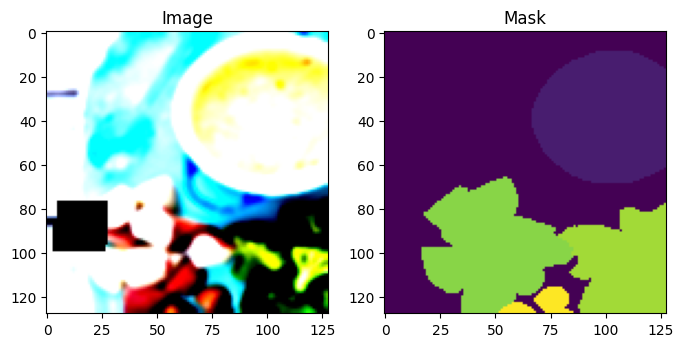

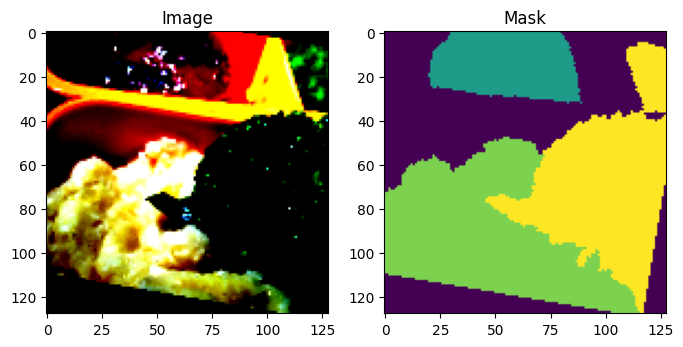

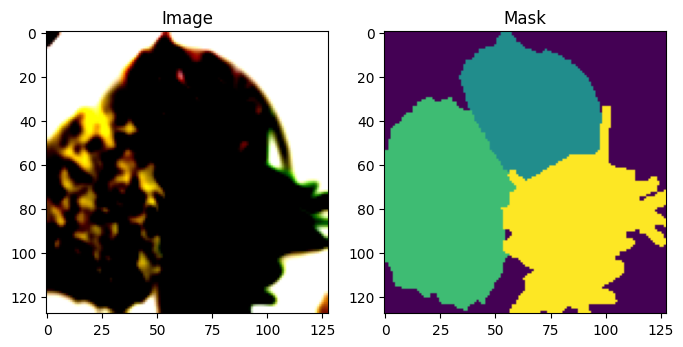

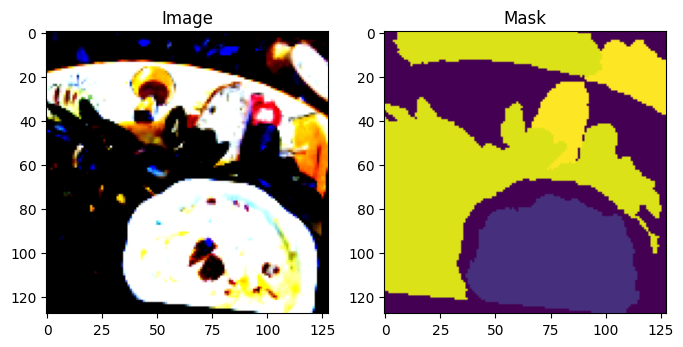

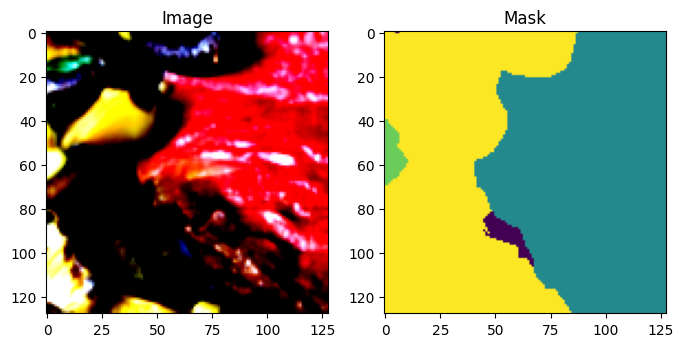

In [12]:
for i in range(100,105):
    img, mask = train_dataset[i]
    visualize_img(img, mask)

In [13]:
IGNORE_INDEX = 255   # 마스크에서 배경/무시 라벨이 255라면 그대로 사용

# -----------------------------
# Model: DeepLabV3+ (ResNet50)
# -----------------------------
model = smp.DeepLabV3Plus(
    encoder_name="mit_b2",# 백본 
    encoder_weights="imagenet",     # 사전학습 가중치
    in_channels=3,                  # RGB
    classes=104,                     # 클래스 수
    encoder_output_stride=8      # ★ 여기! output_stride

)

model = model.to(device)

# -----------------------------
# Loss / Optim / Scheduler
# -----------------------------
# CrossEntropyLoss는 로짓 입력을 기대하므로 model 출력에 softmax 필요 없음
loss_func = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
criterion = CompositeSegLoss(
    num_classes=104,          # 모델 출력 채널 수와 동일
    ignore_index=IGNORE_INDEX,  # 보통 255
    ce_weight=0.7,            # 처음은 0.7/0.3 권장
    dice_weight=0.3,
    use_iou=False,            # True면 CE+IoU, False면 CE+Dice
    class_weight=None,         # 있으면 Tensor[C] 전달 (선택)
    use_ohem=True,       # ★ 켜기
    ohem_ratio=0.2,      # ★ 상위 20% 하드 픽셀
    ohem_min_kept=10000  # ★ 최소 픽셀 수 (256x256, B가 작으면 5k~10k 권장)
)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LR,
    weight_decay=1e-4
)

# 보통 세그멘테이션에서는 'min' 모드로 val_loss를 모니터링
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=3,
    factor=0.1
)

In [14]:
import torch

def calculate_iou(preds, targets, num_classes=None, ignore_index=None):
    """
    preds:   [B,H,W] argmax된 예측 클래스 ID (Long)
    targets: [B,H,W] 정답 클래스 ID (Long)
    num_classes: 총 클래스 수 (None이면 preds/targets에서 추정)
    ignore_index: 무시할 라벨 값 (예: 255). None이면 미사용.

    반환: macro mIoU (torch.Tensor, scalar)
    """
    # 타입/모양 정리
    preds   = preds.long().contiguous().view(-1)
    targets = targets.long().contiguous().view(-1)

    # 무시 라벨 제거
    if ignore_index is not None:
        valid = targets != ignore_index
        preds   = preds[valid]
        targets = targets[valid]

    # 클래스 수 추정(필요시)
    if num_classes is None:
        # 최대 클래스 ID + 1 (빈 클래스가 있어도 OK)
        num_classes = int(torch.max(torch.stack([
            preds.max() if preds.numel() else torch.tensor(0, device=preds.device),
            targets.max() if targets.numel() else torch.tensor(0, device=targets.device)
        ])).item() + 1)

    ious = []
    for c in range(num_classes):
        pred_c = preds == c
        true_c = targets == c

        tp = (pred_c & true_c).sum().float()
        fp = (pred_c & (~true_c)).sum().float()
        fn = ((~pred_c) & true_c).sum().float()

        denom = tp + fp + fn
        if denom > 0:
            ious.append(tp / denom)

    if len(ious) == 0:
        return torch.tensor(0.0, device=preds.device)

    return torch.mean(torch.stack(ious))

In [16]:
# --- 고정 설정: 항상 동일하게 사용 ---
criterion.use_ohem = False          # ★ OHEM 끔 (항상)
criterion.ohem_ratio = 0.0          # 의미 없음(꺼짐이니까), 그래도 0으로
criterion.ohem_min_kept = 0
criterion.ce_w, criterion.dice_w = 0.90, 0.10  # ★ CE:Dice = 0.9 : 0.1 고정

# 증강도 스위치 없이 고정 (원하면 유지)
if hasattr(train_dataset, 'joint_transform'):
    train_dataset.joint_transform = train_tf_easy  # 또는 네가 원하는 고정 증강

best_val_loss = float('inf')
base_lr       = LR
warmup_epochs = 5  # 0~4: 선형 워밍업만 적용

for epoch in range(EPOCHS):
    # ---------- LR: 워밍업만, 전환 완충/절반 낮추기 없음 ----------
    if epoch < warmup_epochs:
        scale = (epoch + 1) / warmup_epochs
        for g in optimizer.param_groups:
            g['lr'] = base_lr * scale
    else:
        for g in optimizer.param_groups:
            g['lr'] = base_lr  # 계속 고정

    # ---------- Train ----------
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks  = masks.to(device).long()

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()

    # ---------- Validation ----------
    model.eval()
    val_loss = 0.0
    val_iou  = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks  = masks.to(device).long()
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()

            preds = torch.argmax(outputs, dim=1)
            val_iou += calculate_iou(
                preds, masks, num_classes=104, ignore_index=255
            ).item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss   = val_loss / len(val_loader)
    avg_val_iou    = val_iou  / len(val_loader)

    # ---------- Scheduler ----------
    # ReduceLROnPlateau는 계속 유지(원하면 patience/factor 완만하게)
    scheduler.step(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1:03d} | LR {current_lr:.6f} | "
          f"Train {avg_train_loss:.4f} | Val {avg_val_loss:.4f} | mIoU {avg_val_iou:.4f}")

    # ---------- Checkpoint ----------
    import os
    os.makedirs('checkpoints', exist_ok=True)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'checkpoints/best_model_3.pth')

Epoch 001 | LR 0.000060 | Train 2.2809 | Val 2.0132 | mIoU 0.1301
Epoch 002 | LR 0.000120 | Train 2.0232 | Val 1.8839 | mIoU 0.1566
Epoch 003 | LR 0.000180 | Train 1.8984 | Val 1.8178 | mIoU 0.1615
Epoch 004 | LR 0.000240 | Train 1.8599 | Val 1.8334 | mIoU 0.1490
Epoch 005 | LR 0.000300 | Train 1.8580 | Val 1.8260 | mIoU 0.1483
Epoch 006 | LR 0.000300 | Train 1.8277 | Val 1.8627 | mIoU 0.1482
Epoch 007 | LR 0.000300 | Train 1.7919 | Val 1.7872 | mIoU 0.1498
Epoch 008 | LR 0.000300 | Train 1.7688 | Val 1.7942 | mIoU 0.1529
Epoch 009 | LR 0.000300 | Train 1.7540 | Val 1.7915 | mIoU 0.1527
Epoch 010 | LR 0.000300 | Train 1.7258 | Val 1.8209 | mIoU 0.1399
Epoch 011 | LR 0.000300 | Train 1.7032 | Val 1.7404 | mIoU 0.1611
Epoch 012 | LR 0.000300 | Train 1.6922 | Val 1.7265 | mIoU 0.1663
Epoch 013 | LR 0.000300 | Train 1.6765 | Val 1.7110 | mIoU 0.1593
Epoch 014 | LR 0.000300 | Train 1.6591 | Val 1.7731 | mIoU 0.1588
Epoch 015 | LR 0.000300 | Train 1.6530 | Val 1.7800 | mIoU 0.1509
Epoch 016 

import torch
from torch import nn

# AMP 장치 결정
if torch.cuda.is_available():
    from torch.amp import GradScaler, autocast
    device_type = "cuda"
    use_amp = True
    scaler = GradScaler(device_type)
else:
    # MPS/CPU: AMP 비활성
    autocast = None
    scaler = None
    use_amp = False
    device_type = "mps" if torch.backends.mps.is_available() else "cpu"

device = torch.device("cuda" if device_type=="cuda"
                      else "mps" if device_type=="mps"
                      else "cpu")
model.to(device)
# ----- Schedules -----
best_val_loss   = float('inf')
base_lr         = LR
warmup_epochs   = 5          # 0~4: LR 선형 워밍업
ohem_stage1_ep  = 15         # 0~14: 안정화 (OHEM off, CE↑)
ohem_stage2_ep  = 25         # 15~24: 완만한 적응


# (선택) 증강 스위치: 초반엔 easy, 이후 strong
if hasattr(train_dataset, 'joint_transform'):
    train_dataset.joint_transform = train_tf_easy  # 시작은 약하게

for epoch in range(EPOCHS):
    # ---------- OHEM & 손실 비율 ----------
    if epoch < ohem_stage1_ep:
        # 완전 안정화
        criterion.use_ohem = False
        criterion.ohem_ratio = 0.0
        criterion.ohem_min_kept = 0
        criterion.ce_w, criterion.dice_w = 0.90, 0.10
    elif epoch < ohem_stage2_ep:
        # 아주 약하게
        criterion.use_ohem = True
        criterion.ohem_ratio = 0.05
        criterion.ohem_min_kept = 4000
        criterion.ce_w, criterion.dice_w = 0.85, 0.15
    else:
        # 점진 강화
        criterion.use_ohem = True
        criterion.ohem_ratio = 0.10   # 필요 시 0.15까지
        criterion.ohem_min_kept = 8000
        criterion.ce_w, criterion.dice_w = 0.80, 0.20
    if epoch == ohem_stage1_ep and hasattr(train_dataset, 'joint_transform'):
        train_dataset.joint_transform = train_tf_strong

     # ---------- LR 워밍업 & 전환 완충 ----------
    if epoch < warmup_epochs:
        scale = (epoch + 1) / warmup_epochs
        for g in optimizer.param_groups:
            g['lr'] = base_lr * scale
    elif epoch in {ohem_stage1_ep, ohem_stage2_ep}:
        for g in optimizer.param_groups:
            g['lr'] = max(base_lr * 0.5, 1e-5)

    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks  = masks.to(device).long()

        optimizer.zero_grad(set_to_none=True)

        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()

    # ---------- Validation ----------
    model.eval()
    val_loss = 0.0
    val_iou  = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks  = masks.to(device).long()
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()

            preds = torch.argmax(outputs, dim=1)
            val_iou += calculate_iou(preds, masks, num_classes=104, ignore_index=255).item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss   = val_loss / len(val_loader)
    avg_val_iou    = val_iou  / len(val_loader)

    # ReduceLROnPlateau는 워밍업 이후에만
    if epoch >= warmup_epochs:
        scheduler.step(avg_val_loss)

    # 현재 LR 로깅(디버깅용)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1:03d} | LR {current_lr:.6f} | "
          f"Train {avg_train_loss:.4f} | Val {avg_val_loss:.4f} | mIoU {avg_val_iou:.4f}")

    # ----- Checkpoint -----
    import os
    os.makedirs('checkpoints', exist_ok=True)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'checkpoints/best_model_2.pth')

for epoch in range(EPOCHS):
    # ---------- 램프: OHEM/손실비율 ----------
    if epoch < ohem_stage1_ep:
        # OHEM 끔 + CE 비중↑ (안정화)
        criterion.use_ohem = False
        criterion.ohem_ratio = 0.10
        criterion.ohem_min_kept = 5000
        criterion.ce_w, criterion.dice_w = 0.9, 0.1
    elif epoch < ohem_stage2_ep:
        # OHEM 약하게 켬
        criterion.use_ohem = True
        criterion.ohem_ratio = 0.05
        criterion.ohem_min_kept = 4000
        criterion.ce_w, criterion.dice_w = 0.85, 0.15
    else:
        # OHEM 정상 강도
        criterion.use_ohem = True
        criterion.ohem_ratio = 0.10  # 필요 시 0.2까지
        criterion.ohem_min_kept = 8000
        criterion.ce_w, criterion.dice_w = 0.80, 0.20

    # ---------- 램프: 증강 스위치 ----------
    if hasattr(train_dataset, 'joint_transform'):
        if epoch == ohem_stage1_ep:          # 5ep부터 강한 증강
            train_dataset.joint_transform = train_tf_strong

    # ---------- 램프: LR 워ーム업 ----------
    if epoch < warmup_epochs:
        scale = float(epoch + 1) / float(warmup_epochs)
        for g in optimizer.param_groups:
            g['lr'] = LR * scale
    else:
        # 워ーム업 이후부터 스케줄러의 통제에 맡김
        for g in optimizer.param_groups:
            if 'initial_lr' not in g:
                g['initial_lr'] = LR  # 안전빵(없으면 넣어줌)

    # ---------- Train ----------
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks  = masks.to(device).long()

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()

    # ---------- Validation ----------
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks  = masks.to(device).long()
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()

            preds = torch.argmax(outputs, dim=1)
            val_iou += calculate_iou(preds, masks, num_classes=104, ignore_index=255).item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss   = val_loss / len(val_loader)
    avg_val_iou    = val_iou / len(val_loader)

    # 워ーム업 동안은 스케줄러로 LR 내리지 않게 하고 싶으면, 아래 if로 조건 처리
    if epoch >= warmup_epochs:
        scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {  avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'checkpoints/best_model_2.pth')

In [17]:
import torch

# 총 파라미터 개수
total_params = sum(p.numel() for p in model.parameters())
# 학습 가능한 파라미터 개수
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")

model_size_mb = total_params * 4 / (1024 ** 2)
print(f"Model size (float32): {model_size_mb:.2f} MB")

Total params: 25,375,544
Trainable params: 25,375,544
Model size (float32): 96.80 MB


In [18]:
# --- 테스트셋 평가 ---
model.eval()
test_loss = 0.0
test_iou = 0.0

with torch.no_grad():
    for images, masks in test_loader:   # 👉 이미 만든 test_loader 사용
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        
        # 손실 계산
        loss = loss_func(outputs, masks)
        test_loss += loss.item()
        
        # IoU 계산
        preds = torch.argmax(outputs, dim=1)
        batch_miou = calculate_iou(preds, masks, num_classes=104, ignore_index=255)
        test_iou += batch_miou.item ()

avg_test_loss = test_loss / len(test_loader)
avg_test_iou = test_iou / len(test_loader)

print(f"[Test] Loss: {avg_test_loss:.4f}, mIoU: {avg_test_iou:.4f}")

[Test] Loss: 1.3194, mIoU: 0.1757


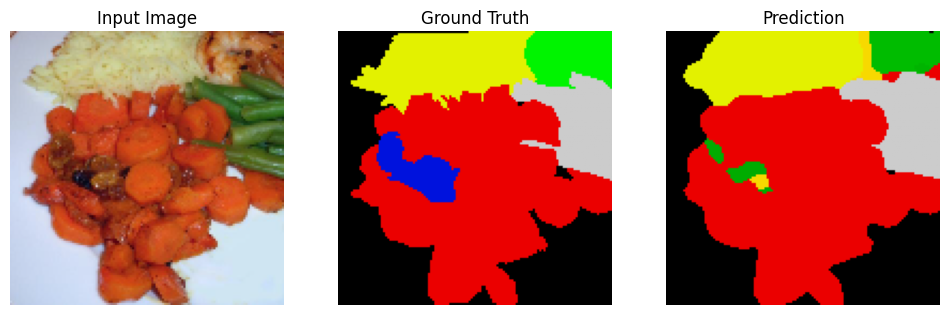

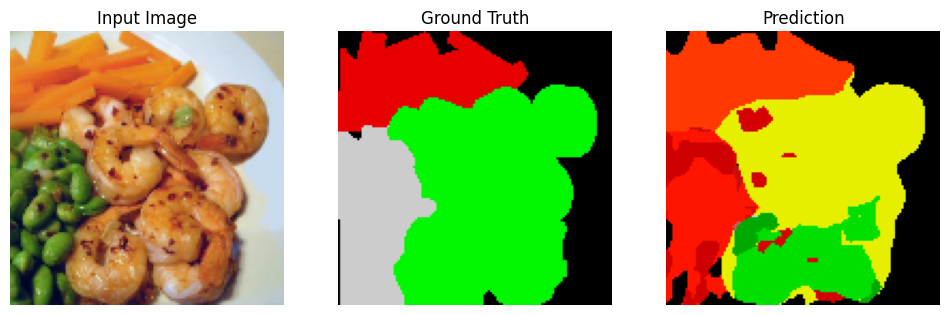

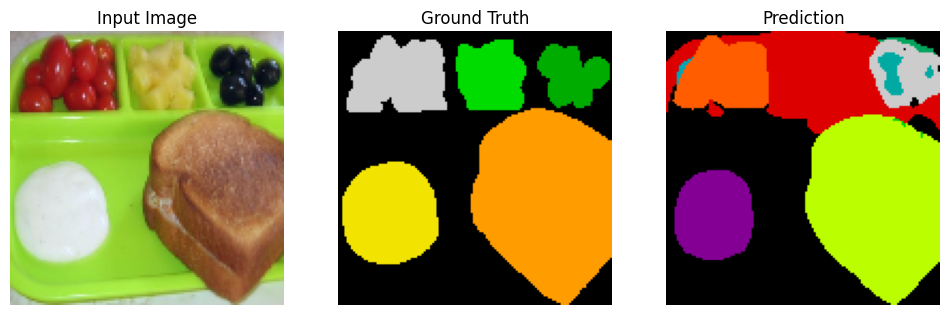

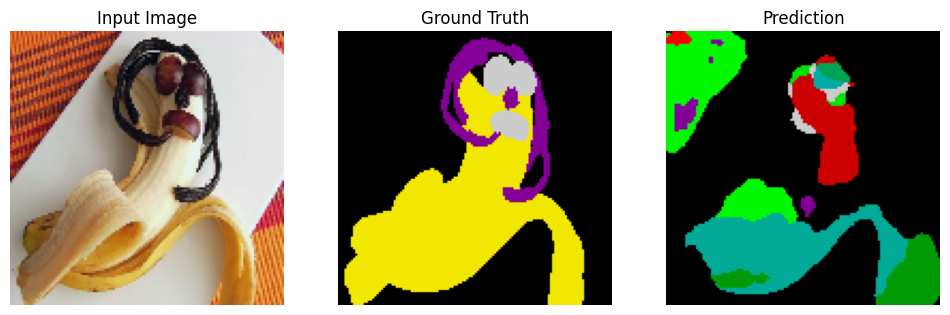

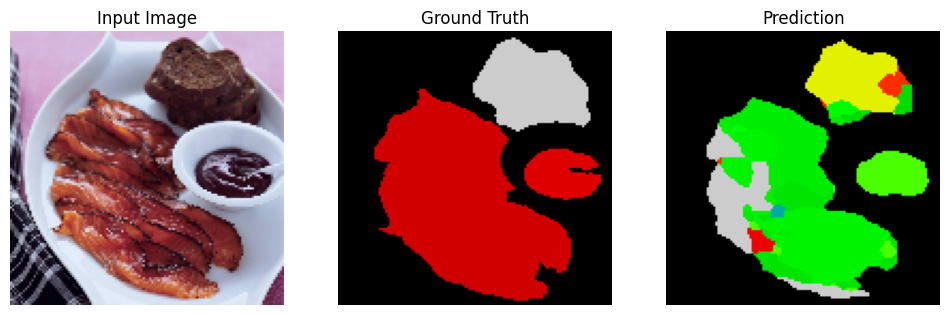

In [19]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions(model, loader, device, num_samples=3):
    model.eval()
    images, masks = next(iter(loader))  # 배치 하나만 뽑음
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    # num_samples개만 보여주기
    for i in range(min(num_samples, images.shape[0])):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        mask_true = masks[i].cpu().numpy()
        mask_pred = preds[i].cpu().numpy()

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow((img - img.min()) / (img.max() - img.min()))  # normalize for display
        axes[0].set_title("Input Image")
        axes[1].imshow(mask_true, cmap="nipy_spectral")
        axes[1].set_title("Ground Truth")
        axes[2].imshow(mask_pred, cmap="nipy_spectral")
        axes[2].set_title("Prediction")
        for ax in axes: ax.axis("off")
        plt.show()

# 실행
visualize_predictions(model, test_loader, device, num_samples=5)